# Analyze Edeka Products

### Brands

https://www.edeka.de/unsere-marken/index.jsp

- Edeka
- Edeka Bio
- Gut & Günstig
- ...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen, urlretrieve
from urllib.parse import urlencode
from pathlib import Path
import json
import math
from typing import Union
from slugify import slugify

In [2]:
scope = "de"
API_URL = f"https://{scope}.openfoodfacts.org/api/v2/search?"

# no_nutrition_data, nutrition_data_per, nutrition_data_prepared_per, serving_size
# nutriscore_grade

PARAMS = {
    "page_size": 1000,
#    "states_tags": "nutrition-facts-completed",
    "brands_tags": "Edeka",
    "sort_by": "unique_scans_n",
    "fields": "code,brands,stores,product_name,categories,nutriscore_grade,ecoscore_grade,nova_group,compared_to_category,unique_scans_n"
}

DATA_FILE = f"./off_{scope}_edeka_top1000.json"

# skip download if data has been downloaded before
if not Path(DATA_FILE).exists():
    urlretrieve(API_URL + urlencode(PARAMS), DATA_FILE)

## Data Preparation

In [3]:
# load json file
with open(DATA_FILE) as f:
    data = json.load(f)

# create data frame from product information
prod_df = (pd.DataFrame(data['products'])
            .drop(['categories', 'compared_to_category'], axis=1)
            .set_index('code')
          )

def is_flag(value: Union[str, int]):
    try:
        return 1 == (int(value) if isinstance(value, str) and value != "" else value)
    except ValueError as e:
        print(f"cannot parse {value}", e)
        return False

# extract product type flags and energy values
flags = ["is_beverage", "is_cheese", "is_fat", "is_water"]

# process brands
prod_df["brand"] = prod_df.brands.map(lambda x: slugify(x)).map(lambda x: "Gut & Günstig" if "gut" in x and "gunstig" in x else ("Edeka Bio" if "edeka-bio" in x else "Edeka"))

display(prod_df)

,brands,ecoscore_grade,nova_group,nutriscore_grade,product_name,stores,unique_scans_n,brand
code,,,,,,,,
4311501489819,"Gut & Günstig, Edeka",c,1.0,a,"H-Milch 1,5%",Edeka,53,Gut & Günstig
4311501695135,"Edeka Bio,Edeka",b,3.0,b,Haferdrink Classic,"Edeka,Konsum",30,Edeka Bio
4311596440429,"Gut & Günstig, Edeka",b,1.0,a,Tomaten passiert,"EDEKA,Marktkauf",28,Gut & Günstig
4311501687734,"Gut & Günstig,Edeka, Gut & Günstig, Gut & Günstig",d,3.0,d,Käse Frischkäse Pur,Edeka,23,Gut & Günstig
4311501492246,"Gut & Günstig, Edeka, Gut & Günstig, Gut & Gün...",b,1.0,a,Haferflocken extra zart,Edeka,22,Gut & Günstig
...,...,...,...,...,...,...,...,...
4311501760079,"Gut & Günstig, Edeka",unknown,4.0,d,Mozzarella Sticks,Edeka,2,Gut & Günstig
4311501698242,Edeka,d,2.0,c,Natives Olivenöl extra,NaN,2,Edeka
4311501351536,Edeka,a,NaN,a,Champignons pilze,NaN,2,Edeka


# Exploratory Data Analysis

### Brands

Unfortunately, many different spelling variations of the same brand

In [4]:
prod_df.brand.value_counts()

brand
Edeka            637
Gut & Günstig    287
Edeka Bio         76
Name: count, dtype: int64

In [5]:
# brands
prod_df.brands.map(lambda x: x.split(","))
brands_s = pd.Series([brand for brands in prod_df.brands for brand in map(lambda x: x.strip(), brands.split(","))])
brands_s.value_counts()

Edeka                  912
Gut & Günstig          498
GUT&GÜNSTIG            292
EDEKA                   84
Edeka Gut & Günstig     74
                      ... 
3x Edeka 01.24           1
2x Edeka 01.24           1
1x Edeka 01.24           1
EDEKA My Veggie          1
Globus                   1
Name: count, Length: 94, dtype: int64

### Stores

In [6]:
prod_df.stores.value_counts(dropna=False)

stores
Edeka                 401
NaN                   284
                      212
EDEKA                  44
Marktkauf              10
Edeka,Marktkauf        10
Marktkauf,Edeka         8
Edeka,Bringmeister      5
Marktkauf, Edeka        4
Netto                   2
Edeka,Konsum            2
Konsum                  2
Marktkauf,EDEKA         2
Spar,Edeka              1
kupsch,Edeka            1
Konsum,Edeka            1
Edeka,Alnatura          1
EDEKA,Kupsch            1
REWE,Edeka              1
EDEKA,Marktkauf         1
EDEKA,Netto             1
Carrefour               1
Edeka Jensen            1
Edeka,NP                1
Alnatura                1
Aldi Süd                1
Edeka,Picnic            1
Name: count, dtype: int64

In [7]:
normalize = lambda x: x.strip().lower().capitalize()
stores_s = pd.Series([store for stores in prod_df.stores for store in (map(normalize, stores.split(",")) if isinstance(stores, str) else [stores])])
stores_s.value_counts(dropna=False)

Edeka           486
NaN             284
                212
Marktkauf        35
Konsum            5
Bringmeister      5
Netto             3
Kupsch            2
Alnatura          2
Rewe              1
Spar              1
Carrefour         1
Edeka jensen      1
Np                1
Aldi süd          1
Picnic            1
Name: count, dtype: int64

### Nutri-Score

In [8]:
nutriscore_colors = ['#00BF00', '#73FF00', '#FFCC00', '#FF6600', '#FF1900', '#000', '#555', '#777']

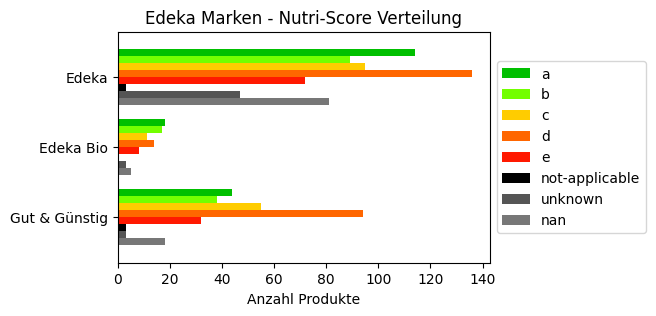

In [9]:
prod_df.groupby("brand").nutriscore_grade.value_counts(dropna=False).sort_index(ascending=True).unstack().plot.barh(color=nutriscore_colors, figsize=(6,3), width=0.8, title="Edeka Marken - Nutri-Score Verteilung")

ax = plt.gca()
ax.invert_yaxis()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel(None)
ax.set_xlabel("Anzahl Produkte");

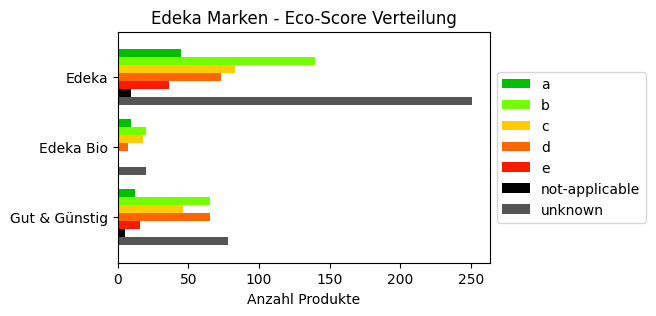

In [10]:
prod_df.groupby("brand").ecoscore_grade.value_counts(dropna=False).sort_index(ascending=True).unstack().plot.barh(color=nutriscore_colors, figsize=(6,3), width=0.8, title="Edeka Marken - Eco-Score Verteilung")

ax = plt.gca()
ax.invert_yaxis()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel(None)
ax.set_xlabel("Anzahl Produkte");

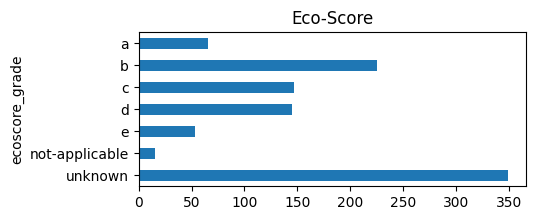

In [11]:
prod_df.ecoscore_grade.value_counts(dropna=False).sort_index(ascending=False).plot.barh(figsize=(5,2), title="Eco-Score");

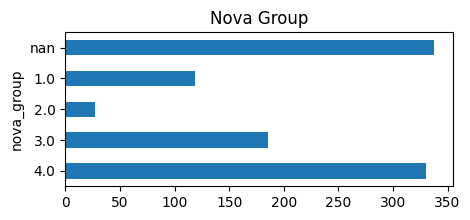

In [12]:
prod_df.nova_group.value_counts(dropna=False).sort_index(ascending=False).plot.barh(figsize=(5,2), title="Nova Group");